# Graduated Non-Convexity (GNC) for robust spatial perceptions




In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani

plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 6})

Often we want to fit models or estimate parameters by casting the problem into a least squares optimization: 

$$
\min_{x\in\cal{X}} \sum_{i=1}^{N} r^2(\bm{y}_i,x)
$$

This works great, if we have no outliers, but suffers severly from outliers, if there are any.

OK, to start and see we first generate some demo data (with additive noise) and plot them to understand what we have got. We use a line as a model, paramtereized by [a,b]

outlier rate: 0.8


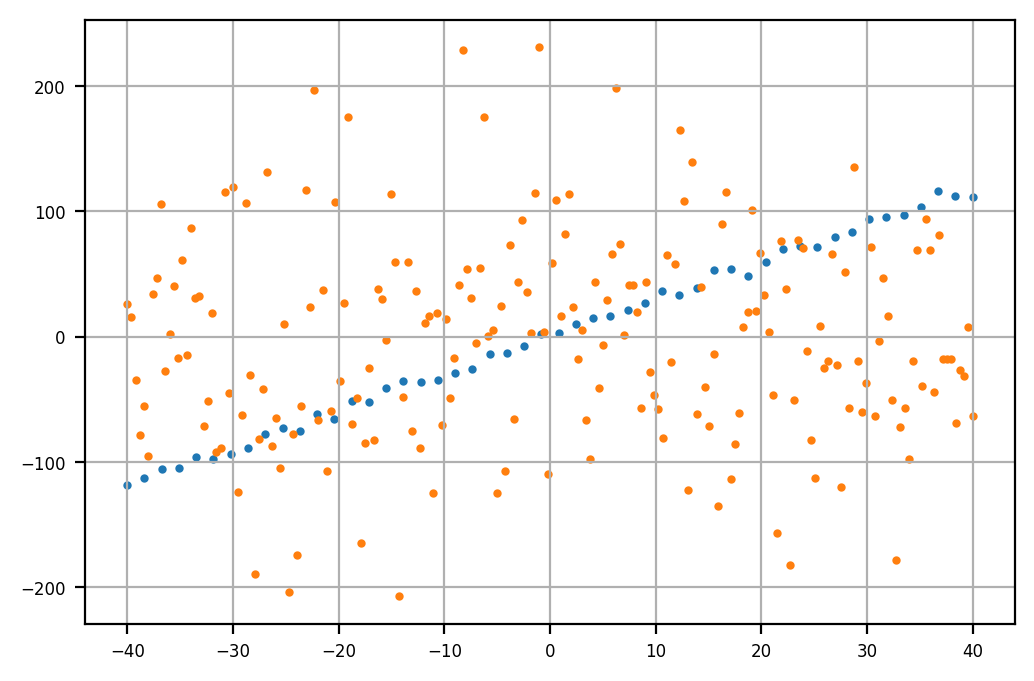

In [7]:
from scipy import optimize
import matplotlib.colors as colors

from numpy.random import default_rng
rng = default_rng()

# let g be a kinear function of x
def linear_model(theta, x):
    return (theta[0] * x + theta[1])

# generate some inlier data
x_data = np.linspace(-40,40)
a=3; b=1; noise = 4
y_data = linear_model([a,b],x_data) + noise * rng.standard_normal(x_data.shape[0])

# generate some outliers

noise2 = 80
x2_data = np.linspace(-40,40,200)
y2_data = noise2 * rng.standard_normal(x2_data.shape[0])

print('outlier rate: ' +  repr(x2_data.size / (x_data.size + x2_data.size)))

plt.scatter(x_data,y_data, s=4)
plt.scatter(x2_data,y2_data, s=4)
# plt.axis('equal')
plt.grid(True)
plt.show()

If we fit a line, with standard least squares, this is what we get: yellow is the line fit, red is ground truth

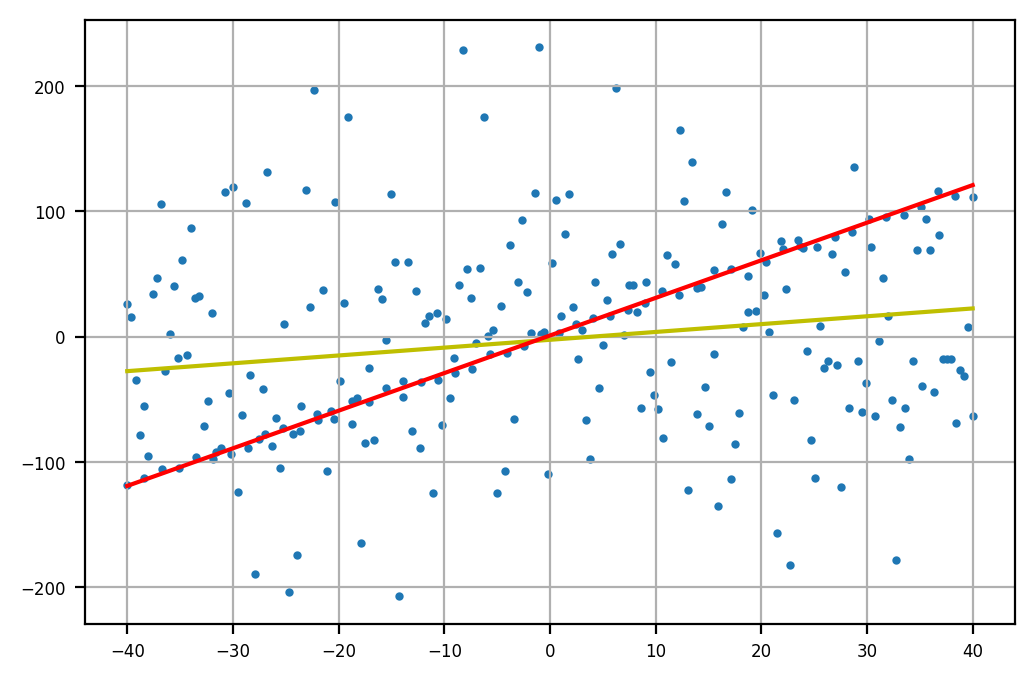

In [8]:
# setup optimization to estimate the parameters, rho is the loss function

def rho(theta,x,y,w):
    return np.sqrt(w)*(linear_model(theta, x) - y)

# do the actual optimization with both inliers and outliers
x_all = np.hstack((x_data,x2_data))
y_all = np.hstack((y_data,y2_data))
weights = np.ones_like(x_all)
theta0 = [0,1]

result = optimize.least_squares(rho, theta0, args=(x_all,y_all,weights),verbose=0)
plt.plot(x_data,linear_model(result.x,x_data), c = 'y')
plt.plot(x_data,linear_model([a,b],x_data), c = 'r')
plt.scatter(x_all,y_all, s=4)
#plt.axis('equal')
plt.grid(True)
plt.show()

A robust cost function $\rho(\cdot)$ limits the influence of outliers on the final estimation result. 

$$
\min_{x\in\cal{X}} \sum_{i=1}^{N} \rho(r^2(\bm{y}_i,x))
$$


Here we Geman McClure (GM), where $\bar{c}$ is a parameter that determinse the shape of the fuction, and $r$ is the residual

$$
\rho(r) = \frac{\bar{c}^2 r^2}{\bar{c}^2 + r^2}
$$

In addition, we add a parameter $\mu$ that allows to adjust the cost function from convex ($\mu \rightarrow \infty$) to the non-convex ($\mu = 1$) function  $\rho(\cdot)$ given above.

$$
\rho_{\mu}(r) = \frac{\mu\bar{c}^2 r^2}{\mu\bar{c}^2 + r^2}
$$

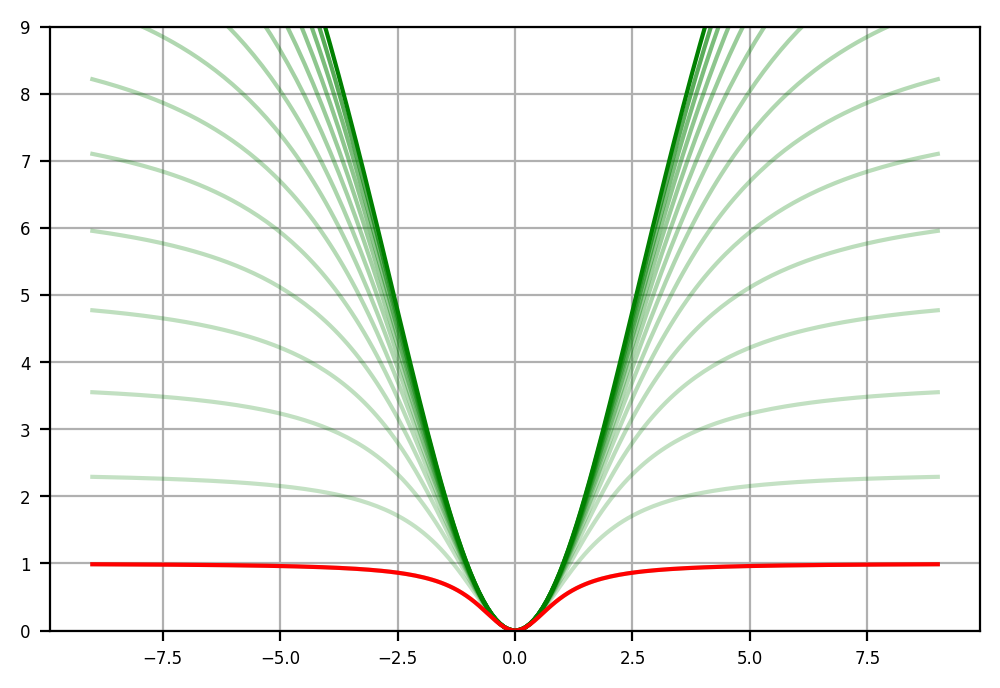

In [9]:
def rho_gm(c,r,mu):
    return (mu*c**2*r**2) / (mu*c**2 + r**2)

c_bar = 1
r_data = np.linspace(-9,9,200)

for mu in np.linspace(1,20,15):
    plt.plot(r_data,rho_gm(c_bar,r_data,mu), c = 'g', alpha = np.sqrt(1/(21-mu)))

plt.plot(r_data,rho_gm(c_bar,r_data,1), c = 'r')

# plt.axis('equal')
plt.ylim([0,9])
plt.grid(True)
plt.show()


Now, let's assume we want to do a robust fit with roboust cost function. We start with a more or less convex cost function, and in an iterative fashion we increase its non-convexity by decreasing $\mu \rightarrow 1$.

For details see Yang et al., "Graduated non-convexity for robust spatial perception: From non-minimal solvers to global outlier rejection." IEEE Robotics and Automation Letters 5.2 (2020): 1127-1134.

[2.93746823 0.39394381]


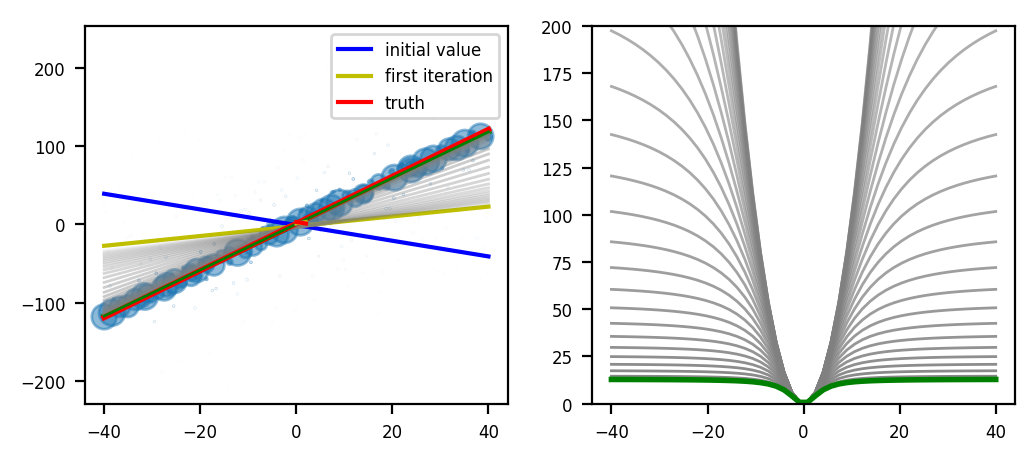

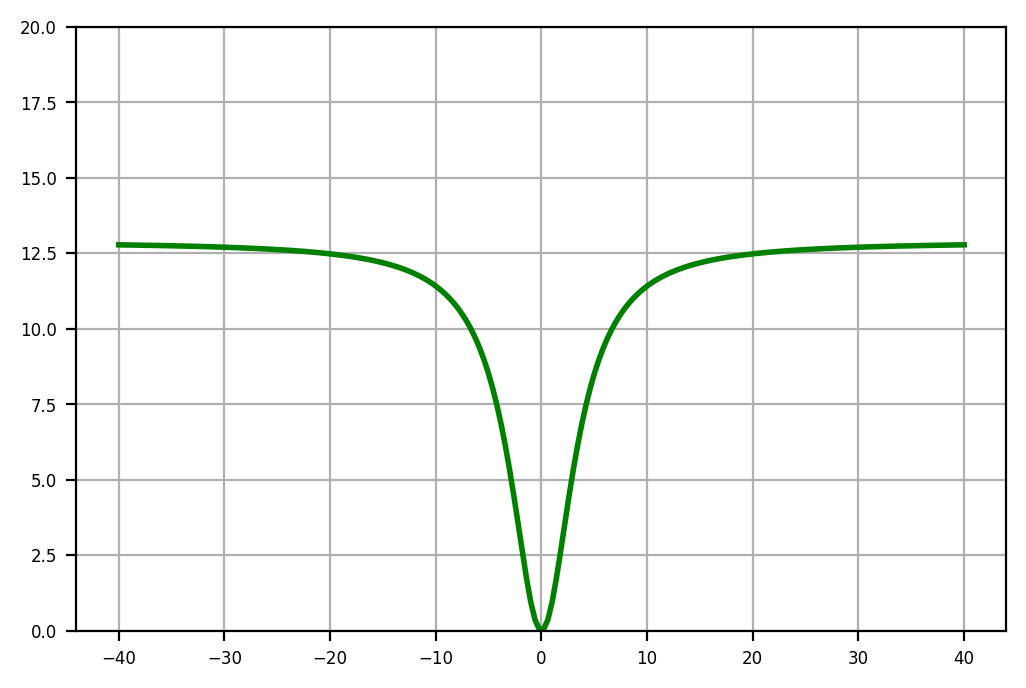

In [12]:
# setup optimization to estimate the parameters, rho is the loss function
def rho(theta,x,y,w):
    return np.sqrt(w)*(linear_model(theta, x) - y)

# setup a figure with two subplots one for the data and one for the rho function
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(6,2.5)
ax2.set_ylim([0,200])

# setup file writer for animatd GIF
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = ani.PillowWriter(fps=8, metadata=metadata)

# initialize the actual optimization with both inliers and outliers
x_all = np.hstack((x_data,x2_data))
y_all = np.hstack((y_data,y2_data))
weights = np.ones_like(x_all)
theta0 = [-1,-1]


# the wheight update according to Yang et al.
def weights_update(resid,c_, mu):
    return (mu*c_*c_ / (resid**2+mu*c_*c_))**2

# plot start value in yellow
ax1.plot(x_data,linear_model(theta0,x_data), c = 'b')

# first iteration (will result into naive fiting  including all outliers) to compute initial residuals needed for first wheight update
result = optimize.least_squares(rho, theta0, args=(x_all,y_all,weights),verbose=0)
residuals = linear_model(result.x, x_all) - y_all
ax1.plot(x_data,linear_model(result.x,x_data), c = 'y')

# create to be animated green line, initially identical to the yellow result of the first iteration
current_fit = ax1.plot(x_data,linear_model(result.x,x_data), c = 'g', linewidth=2)[0]

# set the noise threshold according to Yang et al.
from scipy.stats.distributions import chi2
c_bar = np.sqrt(chi2.ppf(0.8, df=2)*noise)

# initialize mu
mu = mu_start = 2 * (np.max(residuals)**2)/(c_bar**2)

#perform first wheights update 
weights = weights_update(residuals,c_bar, mu)

size = 90 * weights
scat = ax1.scatter(x_all, y_all, s=size, alpha=0.5)


iter_count = 0

with writer.saving(fig, "gnc_demo.gif", fig.dpi*3):
    while (mu > 1):
        alpha = ((iter_count / 50)) #**2

        ax1.plot(x_data,linear_model(theta0,x_data), c = 'grey', alpha = alpha, linewidth=1)
        ax2.plot(x_data,rho_gm(c_bar,x_data,mu), c = 'grey', alpha = alpha, linewidth=1)
        
        # one iteration
        result = optimize.least_squares(rho, theta0, args=(x_all,y_all,weights),verbose=0)
        theta0 = result.x 
        residuals = linear_model(result.x, x_all) - y_all
        weights = weights_update(residuals,c_bar, mu)
        mu = mu / 1.2
        iter_count = iter_count+1
        
        # update plot for animation
        size = 90 * weights
        #size[size < 0.1] = 0.1
        scat.set_sizes(size)
        current_fit.set_data(x_data, linear_model(result.x, x_data))
        
        writer.grab_frame()

    # plot the final results
    ax1.plot(x_data,linear_model([a,b],x_data), c = 'r', linewidth=2)
    ax1.plot(x_data,linear_model(result.x,x_data), c = 'g', linewidth=1)

    ax2.plot(x_data,rho_gm(c_bar,x_data,1), c = 'g', linewidth=2)

    # add a lengend
    blue_line, = ax1.plot([1, 2, 3], c='b', label='initial value')
    yellow_line, = ax1.plot([1, 2, 3], c='y', label='first iteration')
    red_line, = ax1.plot([3, 2, 1], c='r', label='truth')
    ax1.legend(handles=[blue_line, yellow_line, red_line])

    for i in range(20):
        writer.grab_frame() 

print(theta0)


plt.figure(3)
x_data3 = np.linspace(-40,40,200)

plt.plot(x_data3,rho_gm(c_bar,x_data3,1), c = 'g', linewidth=2)
plt.ylim([0,20])

plt.grid(True)
plt.show()
